In [1]:
!pip install -q chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np # type: ignore
import time
import torch
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import DataLoader # type: ignore
from chess import pgn # type: ignore
from tqdm import tqdm # type: ignore
import gdown
import random
# import chess.pgn

In [3]:
!gdown https://drive.google.com/uc?id=1ZNjTwd8HGVxFj8UdT4GfgxE7kbNg9uxa
!gdown https://drive.google.com/uc?id=1WBbZPZuOEmEYj_KJ1tGNcHDTiPbFKHPm
!gdown https://drive.google.com/uc?id=1RDW72vflsg0Dhl6rpamytRlWZkI5nR1q
!gdown https://drive.google.com/uc?id=1Ksc12luabBHx3yIWr7DXrn2E5PCmpRIE
!gdown https://drive.google.com/uc?id=1gpQ06MVRYZh7n6PFDPkaKK44rTqli7FI


Downloading...
From (original): https://drive.google.com/uc?id=1ZNjTwd8HGVxFj8UdT4GfgxE7kbNg9uxa
From (redirected): https://drive.google.com/uc?id=1ZNjTwd8HGVxFj8UdT4GfgxE7kbNg9uxa&confirm=t&uuid=07e807b6-e5e7-4903-9919-0aeff5d2fbe3
To: /content/lichess_elite_2024-01.zip
100% 71.4M/71.4M [00:00<00:00, 172MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WBbZPZuOEmEYj_KJ1tGNcHDTiPbFKHPm
From (redirected): https://drive.google.com/uc?id=1WBbZPZuOEmEYj_KJ1tGNcHDTiPbFKHPm&confirm=t&uuid=abf310c1-2388-440f-9277-946590ded9f7
To: /content/lichess_elite_2024-02.zip
100% 61.7M/61.7M [00:00<00:00, 151MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RDW72vflsg0Dhl6rpamytRlWZkI5nR1q
From (redirected): https://drive.google.com/uc?id=1RDW72vflsg0Dhl6rpamytRlWZkI5nR1q&confirm=t&uuid=c33a35fb-31cc-4b85-aad9-6b6e785fce5f
To: /content/lichess_elite_2024-03.zip
100% 79.4M/79.4M [00:00<00:00, 185MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1

In [4]:
import os

directory = "data/pgn"
os.makedirs(directory, exist_ok=True)

In [5]:
!unzip -q lichess_elite_2024-01.zip -d data/pgn/
!unzip -q lichess_elite_2024-02.zip -d data/pgn/
!unzip -q lichess_elite_2024-03.zip -d data/pgn/
!unzip -q lichess_elite_2024-04.zip -d data/pgn/
!unzip -q lichess_elite_2024-05.zip -d data/pgn/

In [6]:
import chess.pgn

def load_pgn(file_path, max_games=None):
    games = []
    with open(file_path, 'r') as pgn_file:
        for i in range(max_games if max_games else float('inf')):
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            games.append(game)
    return games

games = load_pgn('data/pgn/lichess_elite_2024-01.pgn', max_games=100)


In [7]:
# def pick_game(pgn, index):
#     offset = 0
#     for _ in range(index):
#         offset = pgn.tell()
#         chess.pgn.read_headers(pgn)
#     pgn.seek(offset)
#     return chess.pgn.read_game(pgn)

# def num_games(pgn):
#     num = 0
#     while chess.pgn.read_headers(pgn):
#         num += 1
#     return num

In [8]:
# total_num_games = num_games(open('data/pgn/lichess_elite_2024-01.pgn', "r"))
# random_game_index = random.randint(1, total_num_games)
# game = pick_game(open('data/pgn/lichess_elite_2024-01.pgn', "r"), random_game_index)

In [7]:
import numpy as np
from chess import Board


def board_to_matrix(board: Board):
    # 8x8 is a size of the chess board.
    # 12 = number of unique pieces.
    # 13th board for legal moves (WHERE we can move)
    # maybe 14th for squares FROM WHICH we can move? idk
    matrix = np.zeros((13, 8, 8))
    piece_map = board.piece_map()

    # Populate first 12 8x8 boards (where pieces are)
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        matrix[piece_type + piece_color, row, col] = 1

    # Populate the legal moves board (13th 8x8 board)
    legal_moves = board.legal_moves
    for move in legal_moves:
        to_square = move.to_square
        row_to, col_to = divmod(to_square, 8)
        matrix[12, row_to, col_to] = 1

    return matrix


def create_input_for_nn(games):
    X = []
    y = []
    for game in games:
        board = game.board()
        for move in game.mainline_moves():
            X.append(board_to_matrix(board))
            y.append(move.uci())
            board.push(move)
    return np.array(X, dtype=np.float16), np.array(y)


def encode_moves(moves):
    move_to_int = {move: idx for idx, move in enumerate(set(moves))}
    return np.array([move_to_int[move] for move in moves], dtype=np.float16), move_to_int

In [8]:
X, y = create_input_for_nn(games)

print(f"NUMBER OF SAMPLES: {len(y)}")

NUMBER OF SAMPLES: 8923


In [9]:
y, move_to_int = encode_moves(y)
num_classes = len(move_to_int)

In [10]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [15]:
from torch.utils.data import Dataset


class ChessDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [13]:
import torch.nn as nn


class ChessModel(nn.Module):
    def __init__(self, num_classes):
        super(ChessModel, self).__init__()
        # conv1 -> relu -> conv2 -> relu -> flatten -> fc1 -> relu -> fc2
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

        # Initialize weights
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x

In [16]:
# Create Dataset and DataLoader
dataset = ChessDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Model Initialization
model = ChessModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda


In [17]:
num_epochs = 50
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(inputs)  # Raw logits

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()
    end_time = time.time()
    epoch_time = end_time - start_time
    minutes: int = int(epoch_time // 60)
    seconds: int = int(epoch_time) - minutes * 60
    print(f'Epoch {epoch + 1 + 50}/{num_epochs + 1 + 50}, Loss: {running_loss / len(dataloader):.4f}, Time: {minutes}m{seconds}s')

100%|██████████| 140/140 [00:02<00:00, 63.31it/s] 


Epoch 51/101, Loss: 6.8748, Time: 0m2s


100%|██████████| 140/140 [00:00<00:00, 222.53it/s]


Epoch 52/101, Loss: 6.2676, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 234.69it/s]


Epoch 53/101, Loss: 5.9325, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 229.02it/s]


Epoch 54/101, Loss: 5.6652, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 217.66it/s]


Epoch 55/101, Loss: 5.4185, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 277.10it/s]


Epoch 56/101, Loss: 5.1804, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 243.24it/s]


Epoch 57/101, Loss: 4.9528, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 140.33it/s]


Epoch 58/101, Loss: 4.7180, Time: 0m1s


100%|██████████| 140/140 [00:00<00:00, 140.63it/s]


Epoch 59/101, Loss: 4.4653, Time: 0m1s


100%|██████████| 140/140 [00:00<00:00, 148.82it/s]


Epoch 60/101, Loss: 4.2085, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 270.90it/s]


Epoch 61/101, Loss: 3.9555, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 283.21it/s]


Epoch 62/101, Loss: 3.7089, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 291.01it/s]


Epoch 63/101, Loss: 3.4644, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 281.76it/s]


Epoch 64/101, Loss: 3.2330, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 292.28it/s]


Epoch 65/101, Loss: 3.0224, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 281.09it/s]


Epoch 66/101, Loss: 2.8169, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 293.27it/s]


Epoch 67/101, Loss: 2.6374, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 275.36it/s]


Epoch 68/101, Loss: 2.4781, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 295.50it/s]


Epoch 69/101, Loss: 2.3048, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 285.09it/s]


Epoch 70/101, Loss: 2.1640, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 293.46it/s]


Epoch 71/101, Loss: 2.0198, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 283.19it/s]


Epoch 72/101, Loss: 1.9137, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 237.84it/s]


Epoch 73/101, Loss: 1.7839, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 241.49it/s]


Epoch 74/101, Loss: 1.6798, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 233.77it/s]


Epoch 75/101, Loss: 1.5755, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 204.63it/s]


Epoch 76/101, Loss: 1.4855, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 240.19it/s]


Epoch 77/101, Loss: 1.3751, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 219.99it/s]


Epoch 78/101, Loss: 1.2992, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 284.96it/s]


Epoch 79/101, Loss: 1.2180, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 297.23it/s]


Epoch 80/101, Loss: 1.1422, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 284.44it/s]


Epoch 81/101, Loss: 1.0662, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 296.25it/s]


Epoch 82/101, Loss: 1.0019, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 280.18it/s]


Epoch 83/101, Loss: 0.9464, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 296.73it/s]


Epoch 84/101, Loss: 0.8809, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 283.66it/s]


Epoch 85/101, Loss: 0.8274, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 289.74it/s]


Epoch 86/101, Loss: 0.7892, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 284.93it/s]


Epoch 87/101, Loss: 0.7299, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 297.90it/s]


Epoch 88/101, Loss: 0.6969, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 293.18it/s]


Epoch 89/101, Loss: 0.6509, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 293.54it/s]


Epoch 90/101, Loss: 0.6050, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 287.00it/s]


Epoch 91/101, Loss: 0.5821, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 293.72it/s]


Epoch 92/101, Loss: 0.5456, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 289.97it/s]


Epoch 93/101, Loss: 0.5211, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 290.17it/s]


Epoch 94/101, Loss: 0.4911, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 294.92it/s]


Epoch 95/101, Loss: 0.4725, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 250.76it/s]


Epoch 96/101, Loss: 0.4428, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 236.14it/s]


Epoch 97/101, Loss: 0.4171, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 228.12it/s]


Epoch 98/101, Loss: 0.4024, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 212.11it/s]


Epoch 99/101, Loss: 0.3868, Time: 0m0s


100%|██████████| 140/140 [00:00<00:00, 290.38it/s]

Epoch 100/101, Loss: 0.3756, Time: 0m0s


In [19]:
import os

directory = "models"
os.makedirs(directory, exist_ok=True)

In [20]:
torch.save(model.state_dict(), "models/chess_50ep.pth")


In [ ]:

import pickle

with open("models/heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)

In [21]:
def prepare_input(board: Board):
    matrix = board_to_matrix(board)
    X_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0)
    return X_tensor

In [23]:
import pickle

with open("models/heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)

In [24]:
# Load the mapping

with open("models/heavy_move_to_int", "rb") as file:
    move_to_int = pickle.load(file)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the model
model = ChessModel(num_classes=len(move_to_int))
model.load_state_dict(torch.load("models/chess_50ep.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode (it may be reductant)

int_to_move = {v: k for k, v in move_to_int.items()}
# Function to make predictions
def predict_move(board: Board):
    X_tensor = prepare_input(board).to(device)

    with torch.no_grad():
        logits = model(X_tensor)

    logits = logits.squeeze(0)  # Remove batch dimension

    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    legal_moves = list(board.legal_moves)
    legal_moves_uci = [move.uci() for move in legal_moves]
    sorted_indices = np.argsort(probabilities)[::-1]
    for move_index in sorted_indices:
        move = int_to_move[move_index]
        if move in legal_moves_uci:
            return move

    return None

Using device: cuda


<ipython-input-24-0f41783c6862>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/chess_50ep.pth"))


In [25]:
board = Board()


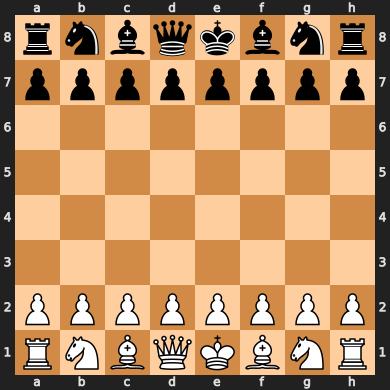

In [26]:
board


In [27]:
board.push_uci("e2e4")


Move.from_uci('e2e4')

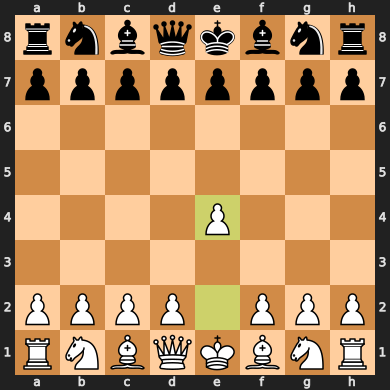

In [28]:
board

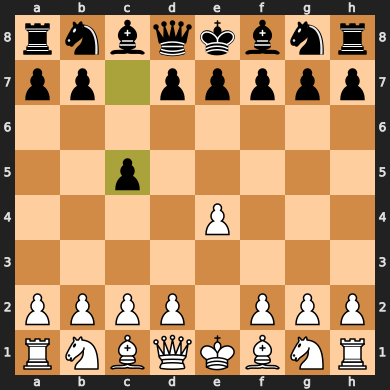

In [29]:
best_move = predict_move(board)
board.push_uci(best_move)
board